In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
from torch.utils.tensorboard import SummaryWriter


In [5]:
sdn_data = pd.read_csv('C:\\Users\\Majid\\Programming Files\\Projects\\DDoS Shield for SDN\\data\\dataset_sdn.csv')
sdn_data.head()

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


## DDoS SDN Dataset Column Breakdown

### Domain Knowledge for DDoS Detection

- **dt**: A timestamp or unique identifier for each record. It helps track the occurrence time of network traffic but may not directly influence DDoS detection.
- **switch**: Represents the specific SDN switch through which the packet traveled. Since SDN relies on centralized control, tracking which switch processed the traffic can help identify load distribution and potential bottlenecks during an attack.
- **src**: The source IP address of the traffic. In DDoS attacks, multiple unique or spoofed source IPs might appear to overwhelm the network, making this a useful feature for anomaly detection.
- **dst**: The destination IP address of the traffic. During a DDoS attack, the destination IP is typically targeted repeatedly, so a high volume of requests to a single destination can indicate malicious activity.
- **packet_count**: Total packets counted in the flow. DDoS attacks often involve a large number of small packets to exhaust network resources, so unusually high packet counts can signify an attack.
- **byte_count**: Total bytes in the data flow. High byte counts over short durations may indicate volumetric attacks (attacks meant to consume bandwidth).
- **flow_duration**: The duration of the traffic flow in milliseconds. Short, repetitive flows with high packet counts may indicate DDoS traffic as attackers typically aim to maximize requests in minimal time.
- **dur_nsec**: Nanosecond precision of the flow duration, adding finer detail to `flow_duration`. This high-precision metric can help in detecting fast, repeated requests typical in certain types of DDoS attacks.
- **tot_dur**: The total duration of the flow in a cumulative format, giving an overview of sustained traffic over time.
- **flows**: The number of flows generated by this source in a single connection. High flow counts are typical in DDoS attacks where a source opens multiple simultaneous connections.
- **packetins**: SDN-specific metric indicating packets sent to the SDN controller. High `packetins` traffic may suggest controller overload, as DDoS attacks in SDN can target the controller directly.
- **pktperflow**: Average packets per flow. This can identify irregular flow behavior as DDoS attacks often have either unusually high or low packets per flow.
- **byteperflow**: Average bytes per flow. Similar to `pktperflow`, abnormal averages in byte-per-flow can hint at an attack.
- **pktrate**: The rate of packet transmission per second. High rates are typical in volumetric DDoS attacks, where attackers attempt to saturate network capacity.
- **Pairflow**: Indicates whether there’s a response to a flow (1 for a bidirectional flow, 0 for unidirectional). In DDoS attacks, unidirectional flows are often observed, as attackers usually don’t wait for responses.
- **protocol**: The protocol type (e.g., TCP, UDP, ICMP). DDoS attacks often exploit specific protocols (e.g., UDP floods), so protocol type helps in attack classification.
- **port_no**: Port number associated with the flow. Certain ports may be targeted more frequently in DDoS attacks, such as HTTP (port 80) or DNS (port 53), making this an important feature for identifying attack types.
- **tx_bytes**: Total bytes transmitted by the source. High transmission can indicate data exfiltration or attempts to saturate network links.
- **rx_bytes**: Total bytes received by the destination. Large incoming traffic volumes over short durations are common in DDoS attacks aimed at overwhelming the recipient.
- **tx_kbps**: Transmission rate in kilobits per second, providing insight into the speed of data flow. High rates may signal volumetric attacks.
- **rx_kbps**: Reception rate in kilobits per second, capturing the speed of incoming data. Like `tx_kbps`, high reception rates can point to attacks that flood a target with traffic.
- **tot_kbps**: The total rate of data flow in kilobits per second (combined `tx` and `rx`). Elevated `tot_kbps` values can highlight potential overloads in traffic that are typical of DDoS attacks.
- **Label**: The target variable, where 0 indicates benign traffic and 1 represents malicious traffic (DDoS). This is the main column for training models to distinguish between normal and attack traffic.


In [6]:
sdn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [7]:
check_missing_values = sdn_data.isnull().sum()
check_missing_values

dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64

In [8]:
#Calculating the mean of the columns with missing values
mean_rx_kbps = sdn_data['rx_kbps'].mean()
mean_tot_kbps = sdn_data['tot_kbps'].mean()

In [9]:
# Fill missing values with the mean using the correct method
sdn_data.fillna({'rx_kbps': mean_rx_kbps, 'tot_kbps': mean_tot_kbps}, inplace=True)

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [11]:
sdn_data.head(10)

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,3,3413,3665,0,0.0,0.0,0
5,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,1,3795,1402,0,0.0,0.0,0
6,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,4,3665,3413,0,0.0,0.0,0
7,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,1,3775,1492,0,0.0,0.0,0
8,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,2,3845,1402,0,0.0,0.0,0
9,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,4,354583059,4295,16578,0.0,16578.0,0


# Explorarty Data Analysis

In [12]:
sdn_data.describe()

,dt,switch,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
count,104345.000000,104345.000000,104345.000000,1.043450e+05,104345.000000,1.043450e+05,1.043450e+05,104345.000000,104345.000000,104345.000000,1.043450e+05,104345.000000,104345.000000,104345.000000,1.043450e+05,1.043450e+05,104345.000000,104345.000000,104345.000000,104345.000000
mean,17927.514169,4.214260,52860.954746,3.818660e+07,321.497398,4.613880e+08,3.218865e+11,5.654234,5200.383468,6381.715291,4.716150e+06,212.210676,0.600987,2.331094,9.325264e+07,9.328039e+07,998.899756,1003.811420,2007.578742,0.390857
std,11977.642655,1.956327,52023.241460,4.877748e+07,283.518232,2.770019e+08,2.834029e+11,2.950036,5257.001450,7404.777808,7.560116e+06,246.855123,0.489698,1.084333,1.519380e+08,1.330004e+08,2423.471618,2049.898551,3136.803677,0.487945
min,2488.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.000000,4.000000,-130933.000000,-1.464426e+08,-4365.000000,0.000000,1.000000,2.527000e+03,8.560000e+02,0.000000,0.000000,0.000000,0.000000
25%,7098.000000,3.000000,808.000000,7.957600e+04,127.000000,2.340000e+08,1.270000e+11,3.000000,1943.000000,29.000000,2.842000e+03,0.000000,0.000000,1.000000,4.743000e+03,3.539000e+03,0.000000,0.000000,0.000000,0.000000
50%,11905.000000,4.000000,42828.000000,6.471930e+06,251.000000,4.180000e+08,2.520000e+11,5.000000,3024.000000,8305.000000,5.521680e+05,276.000000,1.000000,2.000000,4.219610e+06,1.338339e+07,0.000000,0.000000,4.000000,0.000000
75%,29952.000000,5.000000,94796.000000,7.620354e+07,412.000000,7.030000e+08,4.130000e+11,7.000000,7462.000000,10017.000000,9.728112e+06,333.000000,1.000000,3.000000,1.356398e+08,1.439277e+08,251.000000,629.000000,3838.000000,1.000000
max,42935.000000,10.000000,260006.000000,1.471280e+08,1881.000000,9.990000e+08,1.880000e+12,17.000000,25224.000000,19190.000000,1.495387e+07,639.000000,1.000000,5.000000,1.269982e+09,9.905962e+08,20580.000000,16577.000000,20580.000000,1.000000


## Summary Statistics for the DDoS SDN Dataset

### Packet Count (pktcount)
- **Mean**: 52,861
- **Maximum**: 260,006
- Indicates a wide range in the number of packets per flow, which is typical in DDoS scenarios.

### Byte Count (bytecount)
- **Mean**: ~38.2 million bytes
- **Maximum**: ~147 million bytes
- Shows that some flows transfer significantly more data, possibly indicating malicious activity.

### Flow Duration (dur)
- **Average Duration**: 321 ms
- **Maximum Duration**: 1,881 ms
- DDoS attacks may exhibit both short and long durations.

### Packet Rate (pktrate)
- **Mean**: 212 packets per second
- **Minimum**: -4,365 (negative value may indicate data anomalies or measurement artifacts)

### Transmission and Reception Rates (tx_kbps, rx_kbps, tot_kbps)
- **High Variability**: Maximums reaching over 20,000 kbps
- Typical for volumetric attacks aiming to saturate the network.

In [13]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

<Figure size 1000x600 with 0 Axes>

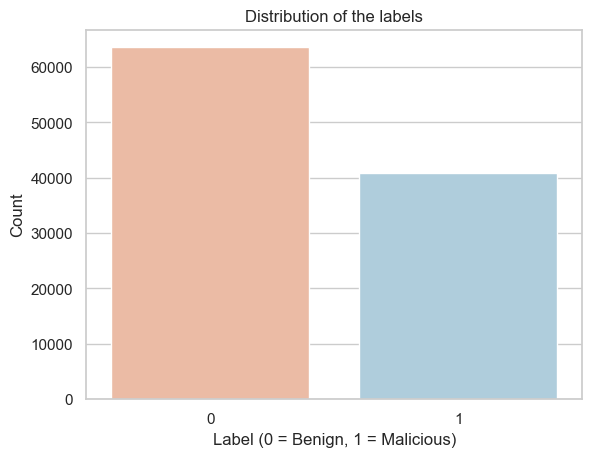

In [14]:
sns.countplot(x='label', hue='label', data=sdn_data, palette='RdBu', legend=False)
plt.title('Distribution of the labels')
plt.xlabel("Label (0 = Benign, 1 = Malicious)")
plt.ylabel("Count")
plt.show()

## Class Distribution
- The target variable `label` shows an imbalance, with the majority of instances being benign (label 0) compared to malicious (label 1).
- This suggests that model performance metrics like precision, recall, and F1-score will be crucial to understanding the classifier's effectiveness.

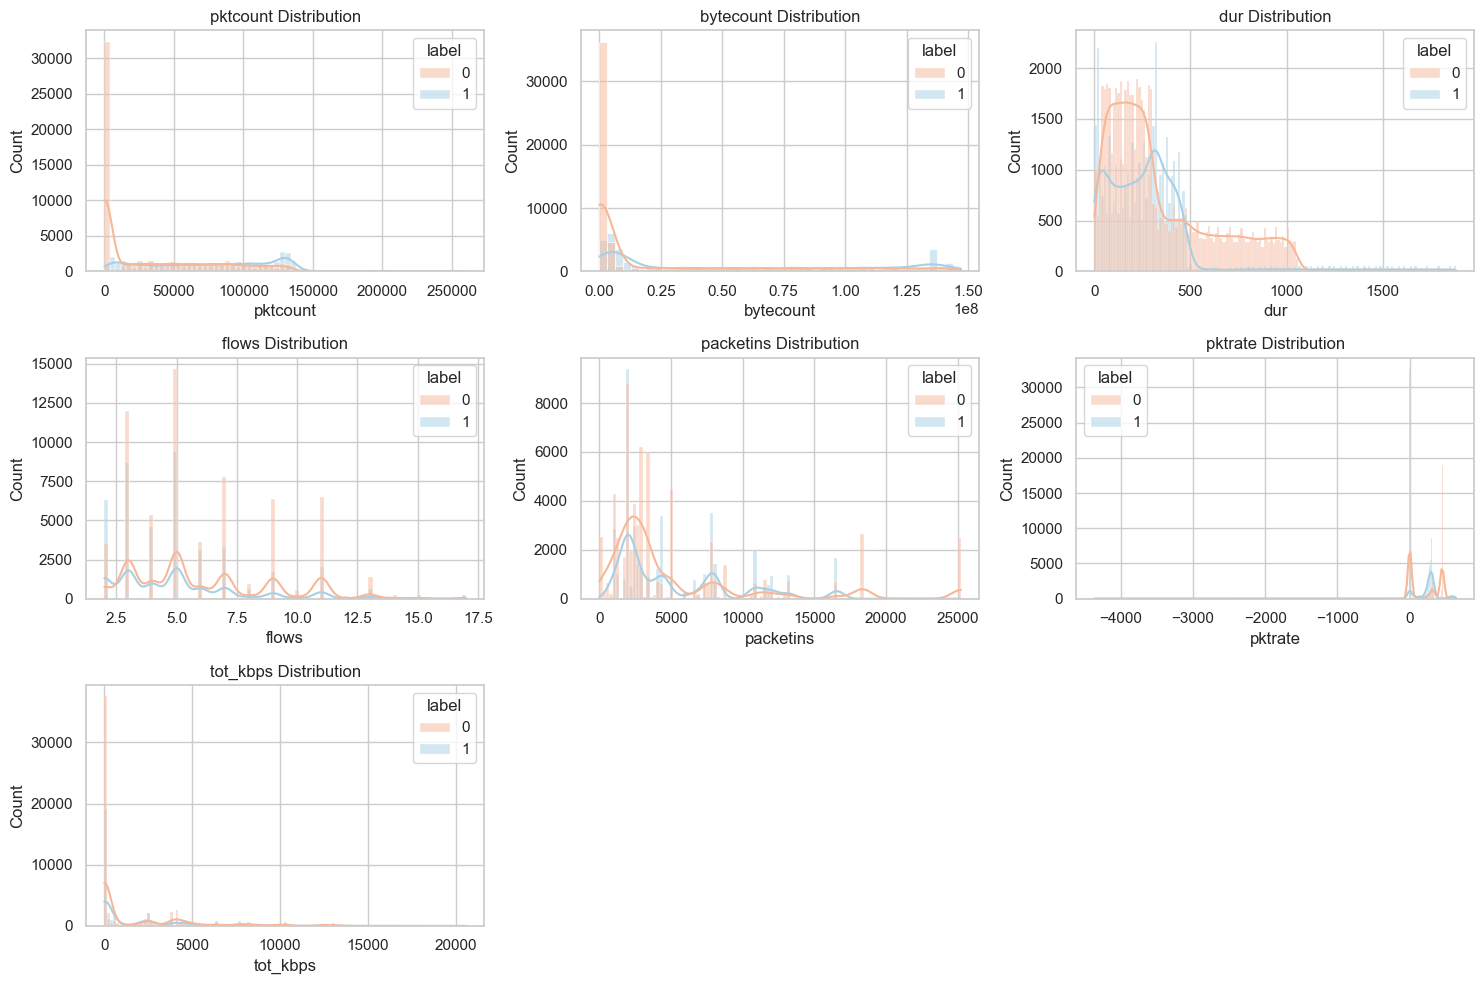

In [15]:
key_features = ['pktcount', 'bytecount', 'dur', 'flows', 'packetins', 'pktrate', 'tot_kbps']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(key_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=sdn_data, x=feature, kde=True, hue='label', palette='RdBu')
    plt.title(f'{feature} Distribution')

plt.tight_layout()
plt.show()

## Insights from Distribution Plots

### Packet Count (pktcount)
- Malicious traffic tends to have a wider distribution with higher packet counts than benign traffic.
- This could indicate the higher volume of packets typically associated with DDoS attacks.

### Byte Count (bytecount)
- Similar to `pktcount`, there’s a wider range in malicious traffic.
- This suggests higher byte transfer rates in DDoS attacks.

### Flow Duration (dur)
- The duration distribution indicates that benign traffic has more frequent, shorter durations.
- Malicious traffic shows some instances with both short and long durations.

### Flows
- The number of flows in benign traffic appears clustered around certain values.
- Malicious traffic has more variability in flow counts.

### Packet-In Messages (packetins)
- Higher packet-in counts are more frequent in malicious traffic.
- This indicates the network controller is likely overwhelmed during attacks.

### Packet Rate (pktrate)
- Negative and extreme values suggest anomalous traffic behavior.
- Malicious traffic shows higher variability.

### Total Kbps (tot_kbps)
- DDoS attacks typically attempt to saturate the network.
- This is reflected in higher `tot_kbps` values for malicious traffic.

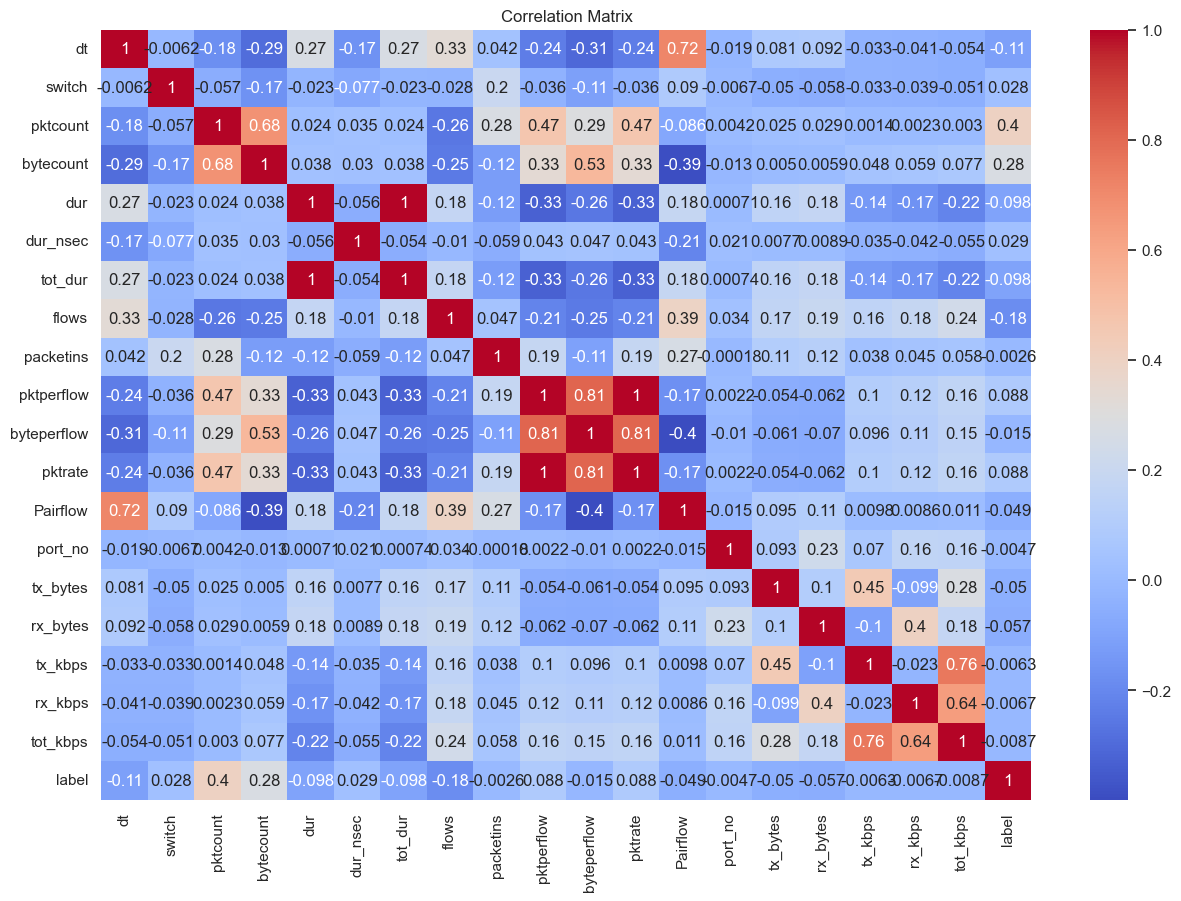

In [16]:
correlation = sdn_data.corr(numeric_only=True)  

plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Correlation Matrix Observations for DDoS SDN Dataset

### High Correlations
- **pktcount** and **bytecount** show a strong positive correlation (0.68), which makes sense as both represent the amount of data transferred.
- **tx_kbps** and **tot_kbps** have a high correlation (0.76), as **tot_kbps** includes **tx_kbps** as part of the total transmission rate.

### Target Correlations (label)

#### Moderate Positive Correlations
- **pktcount** (0.4) and **bytecount** (0.28) show a moderate positive correlation with the target label, suggesting that larger packet and byte counts may be associated with malicious traffic.

#### Weak Correlations
- Other features, such as **flows**, **dur**, and **Pairflow**, show weak correlations with the label, which could still be relevant in the detection model but may not be strongly indicative on their own.

### Low or Negative Correlations
- Some features like **tx_kbps** and **rx_kbps** have low correlations with the label, suggesting they may contribute less directly to distinguishing between benign and malicious traffic.

### Conclusion
This correlation analysis suggests that certain features (like **pktcount**, **bytecount**, and **tot_kbps**) could be more significant indicators for DDoS detection, while others may have minimal impact.

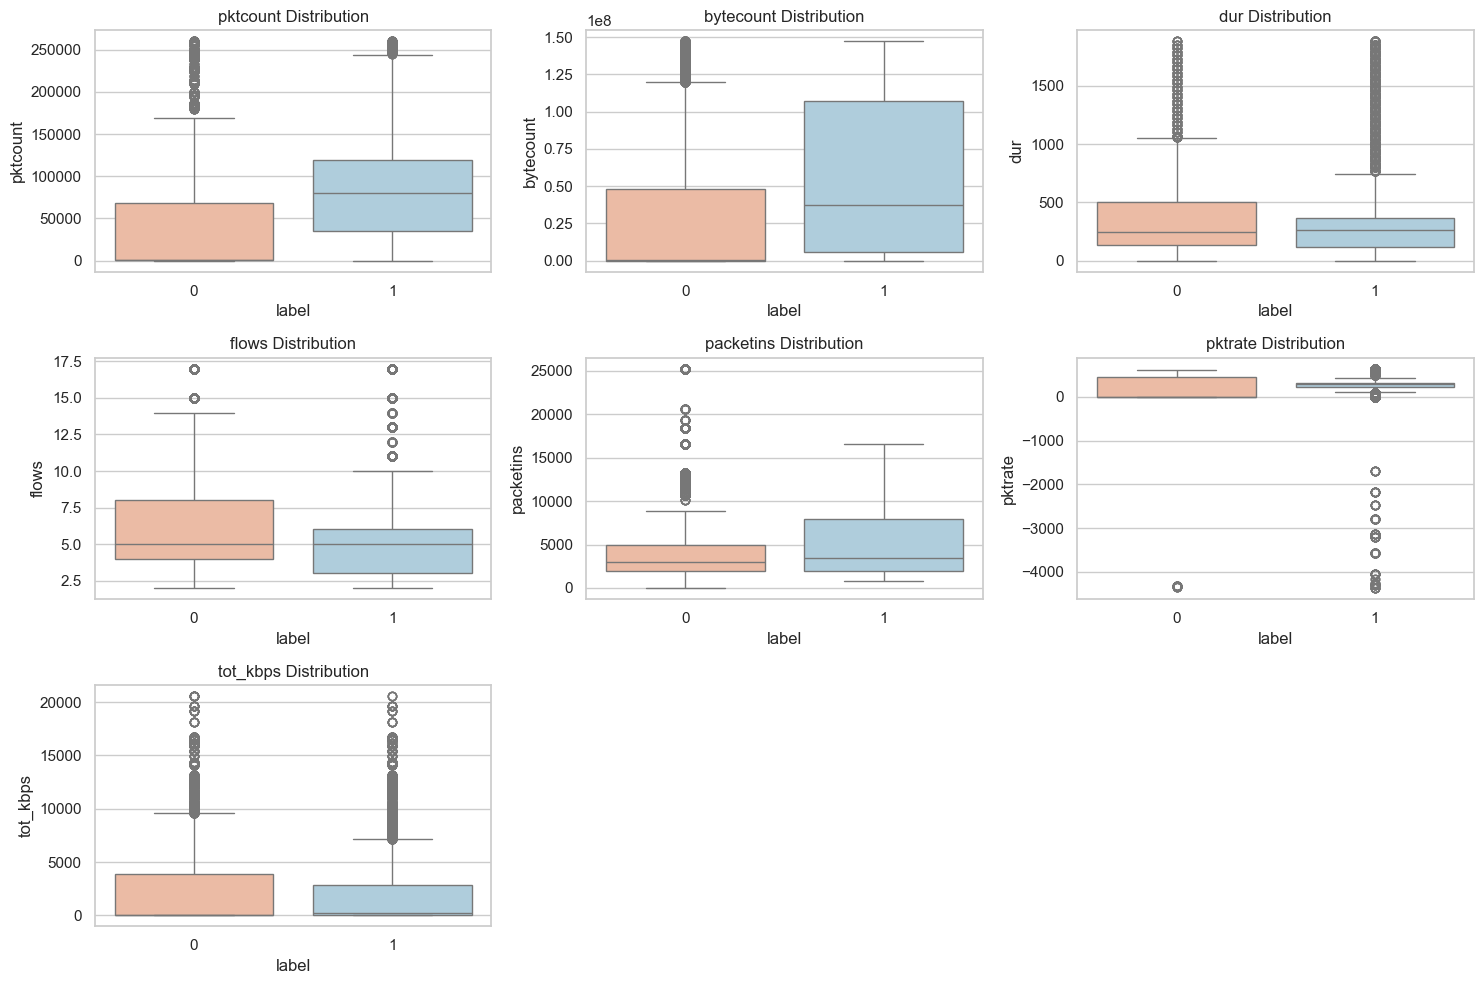

In [17]:
#outliers detection in features

plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=sdn_data, x='label', y=feature, hue='label', palette='RdBu', dodge=False)
    plt.title(f'{feature} Distribution')
    plt.legend([],[], frameon=False)  # Hide the legend
plt.tight_layout()
plt.show()

## Insights from Box Plots

### Packet Count (pktcount)
- Malicious traffic shows a higher median and greater spread, indicating that DDoS attacks often have larger packet counts.
- There are also many outliers in malicious traffic.

### Byte Count (bytecount)
- Malicious traffic has a higher distribution of byte counts compared to benign traffic.
- This suggests larger data transfers in attack scenarios.

### Flow Duration (dur)
- Both benign and malicious traffic have a similar distribution.
- There are more high-duration outliers in malicious traffic.

### Number of Flows (flows)
- Benign traffic has a slightly higher median flow count.
- Malicious traffic shows more variation with outliers, which could be indicative of high-frequency flows during an attack.

### Packet-In Messages (packetins)
- The distribution of packetins is broader in malicious traffic.
- This indicates the controller is likely overwhelmed by frequent packet-ins in DDoS attacks.

### Packet Rate (pktrate)
- Malicious traffic shows some negative outliers, suggesting anomalies or unusual traffic behaviors in attack scenarios.

### Total Kbps (tot_kbps)
- Both benign and malicious traffic show a wide range.
- Malicious traffic has slightly more high-value outliers, which could point to attempts to saturate the network.

# Feature Engineering and Model Training 

In [18]:
#Label encoding

label_encoder = {col: LabelEncoder() for col in ['src','dst','Protocol']}
for col, le in label_encoder.items():
    sdn_data[col] = le.fit_transform(sdn_data[col])

sdn_data.head()

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,0,16,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,2,3,143928631,3917,0,0.0,0.0,0
1,11605,1,0,16,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,2,4,3842,3520,0,0.0,0.0,0
2,11425,1,10,16,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,2,1,3795,1242,0,0.0,0.0,0
3,11425,1,10,16,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,2,2,3688,1492,0,0.0,0.0,0
4,11425,1,10,16,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,2,3,3413,3665,0,0.0,0.0,0


## Splitting Data

In [19]:
#Splitting the data into features and target
X = sdn_data.drop('label', axis=1)
y = sdn_data['label']

X.head(), y.head()

(      dt  switch  src  dst  pktcount  bytecount  dur   dur_nsec       tot_dur  \
 0  11425       1    0   16     45304   48294064  100  716000000  1.010000e+11   
 1  11605       1    0   16    126395  134737070  280  734000000  2.810000e+11   
 2  11425       1   10   16     90333   96294978  200  744000000  2.010000e+11   
 3  11425       1   10   16     90333   96294978  200  744000000  2.010000e+11   
 4  11425       1   10   16     90333   96294978  200  744000000  2.010000e+11   
 
    flows  packetins  pktperflow  byteperflow  pktrate  Pairflow  Protocol  \
 0      3       1943       13535     14428310      451         0         2   
 1      2       1943       13531     14424046      451         0         2   
 2      3       1943       13534     14427244      451         0         2   
 3      3       1943       13534     14427244      451         0         2   
 4      3       1943       13534     14427244      451         0         2   
 
    port_no   tx_bytes  rx_bytes  tx

In [20]:
#Splitting the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((73041, 22), (31304, 22), (73041,), (31304,))

In [77]:


Models = {
    "Naive Bayes": GaussianNB(),
    "linearSVC": LinearSVC(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(kernel='rbf', random_state=42)
}

results = {}

for model_name, model in Models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'confusion_matrix': cm
    }

    print(f"{model_name} - Classification Report:\n", classification_report(y_test, y_pred))

results

Naive Bayes - Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.81      0.73     19112
           1       0.54      0.35      0.42     12192

    accuracy                           0.63     31304
   macro avg       0.60      0.58      0.58     31304
weighted avg       0.62      0.63      0.61     31304

linearSVC - Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.74      0.70     19112
           1       0.49      0.39      0.44     12192

    accuracy                           0.61     31304
   macro avg       0.57      0.57      0.57     31304
weighted avg       0.59      0.61      0.60     31304

Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19112
           1       1.00      1.00      1.00     12192

    accuracy                           1.00     31304
   macro avg  

c:\Users\Majid\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     19112
           1       0.99      0.99      0.99     12192

    accuracy                           0.99     31304
   macro avg       0.99      0.99      0.99     31304
weighted avg       0.99      0.99      0.99     31304

XGBoost - Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19112
           1       1.00      1.00      1.00     12192

    accuracy                           1.00     31304
   macro avg       1.00      1.00      1.00     31304
weighted avg       1.00      1.00      1.00     31304

Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.87      0.78     19112
           1       0.68      0.45      0.54     12192

    accuracy                           0.70     31304
   macro avg 

{'Naive Bayes': {'accuracy': 0.6317722974699719,
  'recall': 0.3480971128608924,
  'precision': 0.5425028761344752,
  'f1': 0.42408193854609044,
  'confusion_matrix': array([[15533,  3579],
         [ 7948,  4244]], dtype=int64)},
 'linearSVC': {'accuracy': 0.6056414515716841,
  'recall': 0.3916502624671916,
  'precision': 0.49211584046171286,
  'f1': 0.4361726421557433,
  'confusion_matrix': array([[14184,  4928],
         [ 7417,  4775]], dtype=int64)},
 'Random Forest': {'accuracy': 1.0,
  'recall': 1.0,
  'precision': 1.0,
  'f1': 1.0,
  'confusion_matrix': array([[19112,     0],
         [    0, 12192]], dtype=int64)},
 'Decision Tree': {'accuracy': 0.9998402760030667,
  'recall': 0.9999179790026247,
  'precision': 0.9996719967199672,
  'f1': 0.9997949727313733,
  'confusion_matrix': array([[19108,     4],
         [    1, 12191]], dtype=int64)},
 'KNN': {'accuracy': 0.8852542806031178,
  'recall': 0.8156988188976378,
  'precision': 0.8808680248007086,
  'f1': 0.8470317690145643,


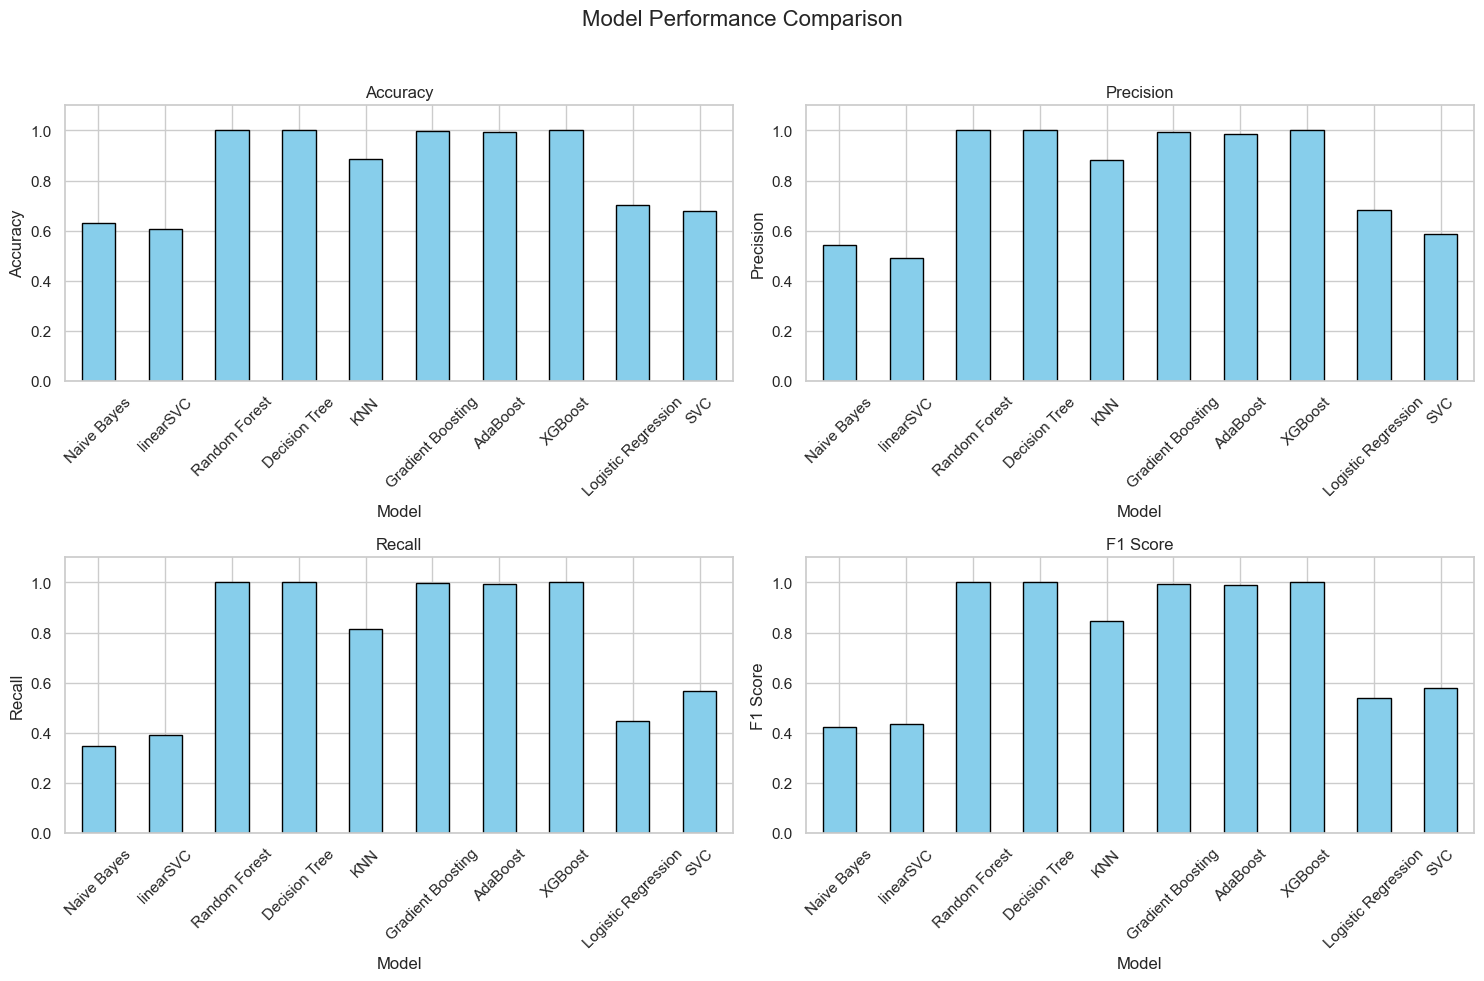

In [78]:
# Organize results data for plotting
model_names = list(results.keys())
accuracy = [results[model]['accuracy'] for model in model_names]
precision = [results[model]['precision'] for model in model_names]
recall = [results[model]['recall'] for model in model_names]
f1_score = [results[model]['f1'] for model in model_names]

# Create a DataFrame to hold the results for plotting
df_results = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})

# Set 'Model' as the index for easier plotting
df_results.set_index('Model', inplace=True)

# Plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

for i, metric in enumerate(metrics):
    row, col = divmod(i, 2)
    df_results[metric].plot(kind='bar', ax=axes[row, col], color='skyblue', edgecolor='black')
    axes[row, col].set_title(f'{metric}')
    axes[row, col].set_ylabel(metric)
    axes[row, col].set_ylim(0, 1.1)
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Model Performance Summary

### Naive Bayes
- **Accuracy**: 63.18%
- **Recall**: 34.81%
- **Precision**: 54.25%
- **F1 Score**: 42.41%
- **Confusion Matrix**:[[15533, 3579], [ 7948, 4244]]


### LinearSVC
- **Accuracy**: 60.56%
- **Recall**: 39.17%
- **Precision**: 49.21%
- **F1 Score**: 43.62%
- **Confusion Matrix**:[[14184, 4928], [ 7417, 4775]]



### Random Forest
- **Accuracy**: 100%
- **Recall**: 100%
- **Precision**: 100%
- **F1 Score**: 100%
- **Confusion Matrix**:19112, 0], [ 0, 12192]]




### Decision Tree
- **Accuracy**: 99.98%
- **Recall**: 99.99%
- **Precision**: 99.97%
- **F1 Score**: 99.98%
- **Confusion Matrix**:[[19108, 4], [ 1, 12191]]
### KNN
- **Accuracy**: 88.53%
- **Recall**: 81.57%
- **Precision**: 88.09%
- **F1 Score**: 84.70%
- **Confusion Matrix**:[[17767, 1345], [ 2247, 9945]]
### Gradient Boosting
- **Accuracy**: 99.65%
- **Recall**: 99.82%
- **Precision**: 99.29%
- **F1 Score**: 99.55%
- **Confusion Matrix**:[[19025, 87], [ 22, 12170]]
### AdaBoost
- **Accuracy**: 99.21%
- **Recall**: 99.29%
- **Precision**: 98.70%
- **F1 Score**: 98.99%
- **Confusion Matrix**:[18952, 160], [ 87, 12105]]
### XGBoost
- **Accuracy**: 100%
- **Recall**: 100%
- **Precision**: 100%
- **F1 Score**: 100%
- **Confusion Matrix**:[[19112, 0], [ 0, 12192]]
### Logistic Regression
- **Accuracy**: 70.39%
- **Recall**: 44.69%
- **Precision**: 68.33%
- **F1 Score**: 54.04%
- **Confusion Matrix**:[[16586, 2526], [ 6743, 5449]]
### SVC
- **Accuracy**: 67.69%
- **Recall**: 56.65%
- **Precision**: 58.85%
- **F1 Score**: 57.73%
- **Confusion Matrix**:[[14282, 4830], [ 5285, 6907]]

# Transition to Deep Learning Models

Now we will proceed to explore Deep Learning models for classifying the DDoS SDN dataset.

In [22]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [23]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)


In [24]:
#Create a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [25]:
# 2. Define the Model Architecture
class DDoSClassifier(nn.Module):
    def __init__(self):
        super(DDoSClassifier, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.out(x))
        return x

# Instantiate the model
model = DDoSClassifier()

In [26]:
# 3. Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='runs/ddos_experiment')

# 4. Train the Model with TensorBoard logging
epochs = 150
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    # Log the average loss to TensorBoard
    writer.add_scalar('Training Loss', avg_loss, epoch)

# Close the writer
writer.close()


Epoch 1/150, Loss: 0.0389
Epoch 2/150, Loss: 0.0379
Epoch 3/150, Loss: 0.0386
Epoch 4/150, Loss: 0.0370
Epoch 5/150, Loss: 0.0362
Epoch 6/150, Loss: 0.0362
Epoch 7/150, Loss: 0.0393
Epoch 8/150, Loss: 0.0369
Epoch 9/150, Loss: 0.0381
Epoch 10/150, Loss: 0.0380
Epoch 11/150, Loss: 0.0402
Epoch 12/150, Loss: 0.0378
Epoch 13/150, Loss: 0.0369
Epoch 14/150, Loss: 0.0365
Epoch 15/150, Loss: 0.0375
Epoch 16/150, Loss: 0.0361
Epoch 17/150, Loss: 0.0360
Epoch 18/150, Loss: 0.0362
Epoch 19/150, Loss: 0.0367
Epoch 20/150, Loss: 0.0357
Epoch 21/150, Loss: 0.0370
Epoch 22/150, Loss: 0.0367
Epoch 23/150, Loss: 0.0355
Epoch 24/150, Loss: 0.0363
Epoch 25/150, Loss: 0.0379
Epoch 26/150, Loss: 0.0391
Epoch 27/150, Loss: 0.0366
Epoch 28/150, Loss: 0.0355
Epoch 29/150, Loss: 0.0348
Epoch 30/150, Loss: 0.0348
Epoch 31/150, Loss: 0.0379
Epoch 32/150, Loss: 0.0375
Epoch 33/150, Loss: 0.0360
Epoch 34/150, Loss: 0.0353
Epoch 35/150, Loss: 0.0376
Epoch 36/150, Loss: 0.0391
Epoch 37/150, Loss: 0.0365
Epoch 38/1

In [28]:
# 5. Evaluate the Model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = (y_pred > 0.5).float()  # Threshold for binary classification

# Convert predictions to numpy for metric calculations
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

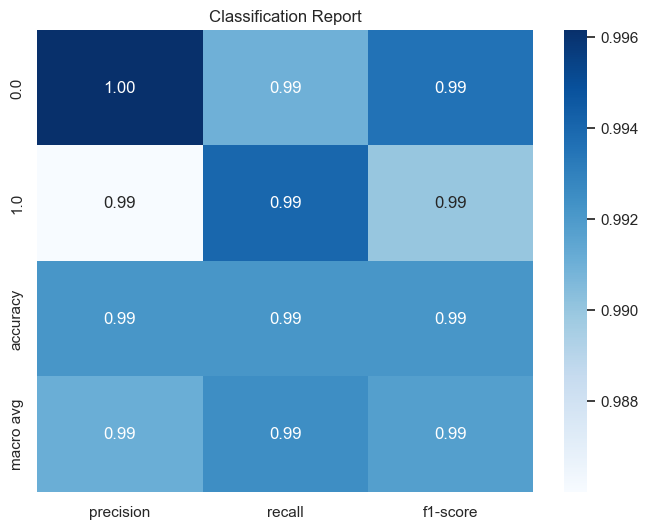

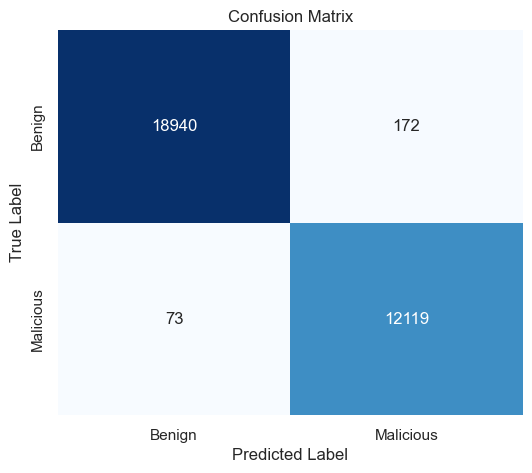

In [29]:
# Classification Report as DataFrame
report = classification_report(y_test_np, y_pred_np, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot Classification Report
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_np)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()